## Import datasetu

In [1]:
import deepchem as dc
import matplotlib.pyplot as plt
import polars as pl
import numpy as np


2025-12-02 20:35:00.938662: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-02 20:35:03.392132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 20:35:07.919004: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [2]:
dc.__version__

'2.6.0.dev'

## Przegląd danych

In [7]:
tasks, datasets, transformers = dc.molnet.load_chembl(
    shard_size=2000, featurizer="ECFP", set="5thresh", splitter="random")

[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerator
[20:39:58] DEPRECATION WARNING: please use MorganGenerat

Łączenie danych w jeden dataset

In [8]:
train_dataset, valid_dataset, test_dataset = datasets

full_dataset = dc.data.DiskDataset.merge(datasets)

In [9]:
# Pobranie nazw zadań (tasks)
tasks = full_dataset.get_task_names()

# Ekstrakcja danych NumPy z obiektu DeepChem Dataset
X_data = full_dataset.X
Y_data = full_dataset.y
W_data = full_dataset.w
mol_ids = full_dataset.ids

In [10]:
# Użycie maski wag (W) do stworzenia maski logicznej
# Tam, gdzie W=0.0, wartość Y jest nieznana.
# Użyjemy tej maski, aby jawnie ustawić NaN.
unknown_mask = (W_data == 0.0)

# Kopia danych Y, gdzie nieznane wartości są ustawione na NaN
Y_data_masked = Y_data.copy()
Y_data_masked[unknown_mask] = np.nan

# 1. Tworzenie Polars DataFrame z Y_data_masked
# Nazwy kolumn bierzemy z listy tasks
df_chembl_y = pl.DataFrame(
    {task: Y_data_masked[:, i] for i, task in enumerate(tasks)}
)

# 2. Dodanie identyfikatorów
df_chembl_y = df_chembl_y.with_columns(
    pl.Series("ID", mol_ids)
)

print("\n--- Fragment Data Frame Polars (Y) ---\n")
print(df_chembl_y.head())


--- Fragment Data Frame Polars (Y) ---

shape: (5, 692)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ CHEMBL107 ┆ CHEMBL107 ┆ CHEMBL107 ┆ CHEMBL107 ┆ … ┆ CHEMBL616 ┆ CHEMBL616 ┆ CHEMBL618 ┆ ID       │
│ 5051      ┆ 5104      ┆ 5145      ┆ 5189      ┆   ┆ 4         ┆ 6         ┆ 4         ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ NaN       ┆ NaN       ┆ NaN       ┆ NaN       ┆ … ┆ NaN       ┆ NaN       ┆ NaN       ┆ Cc1cccc( │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ C)c1OCCN │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ CCOc2ccc │
│           ┆           ┆         

In [11]:
# Utworzenie Polars DataFrame z cechami (X)
# Nadanie kolumnom generycznych nazw (MACCS_0, MACCS_1, ...)
feature_names = [f"MACCS_{i}" for i in range(X_data.shape[1])]
df_chembl_x = pl.DataFrame(
    X_data,
    schema=feature_names
)
df_chembl_x = df_chembl_x.with_columns(
    pl.Series("ID", mol_ids)
)

print("\n--- Fragment Data Frame Polars (X) - Cechy MACCS ---\n")
print(df_chembl_x.head())


--- Fragment Data Frame Polars (X) - Cechy MACCS ---

shape: (5, 1_025)
┌─────────┬─────────┬─────────┬─────────┬───┬────────────┬────────────┬────────────┬───────────────┐
│ MACCS_0 ┆ MACCS_1 ┆ MACCS_2 ┆ MACCS_3 ┆ … ┆ MACCS_1021 ┆ MACCS_1022 ┆ MACCS_1023 ┆ ID            │
│ ---     ┆ ---     ┆ ---     ┆ ---     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---           │
│ f64     ┆ f64     ┆ f64     ┆ f64     ┆   ┆ f64        ┆ f64        ┆ f64        ┆ str           │
╞═════════╪═════════╪═════════╪═════════╪═══╪════════════╪════════════╪════════════╪═══════════════╡
│ 0.0     ┆ 0.0     ┆ 0.0     ┆ 0.0     ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ Cc1cccc(C)c1O │
│         ┆         ┆         ┆         ┆   ┆            ┆            ┆            ┆ CCNCCOc2ccccc │
│         ┆         ┆         ┆         ┆   ┆            ┆            ┆            ┆ 2OCc…         │
│ 0.0     ┆ 0.0     ┆ 0.0     ┆ 0.0     ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ COc1ccc(Nc2nc │
│         ┆       

# EDA

In [12]:
print(f"Liczba próbek (cząsteczek): {len(mol_ids)}")
print(f"Liczba zadań (bioaktywności): {len(tasks)}")
print(f"Nazwy pierwszych 5 zadań: {tasks[:5]}")

Liczba próbek (cząsteczek): 23871
Liczba zadań (bioaktywności): 691
Nazwy pierwszych 5 zadań: ['CHEMBL1075051' 'CHEMBL1075104' 'CHEMBL1075145' 'CHEMBL1075189'
 'CHEMBL1075228']


### Rozkład liczby ustawionych bitów (obecnych cech)

In [16]:
# Obliczenie liczby '1' (ustawionych bitów) w każdym wierszu (dla każdej cząsteczki)
# Pomiń kolumnę 'ID'
fingerprint_data = df_chembl_x.drop("ID").to_numpy()
bit_counts = np.sum(fingerprint_data, axis=1)

# Konwersja na Polars Series dla opisu statystycznego
bit_counts_series = pl.Series("Bit Counts", bit_counts)

print("\n### Podsumowanie liczby aktywnych cech (bitów 1.0) na cząsteczkę:")
print(bit_counts_series.describe())


### Podsumowanie liczby aktywnych cech (bitów 1.0) na cząsteczkę:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 23871.0   │
│ null_count ┆ 0.0       │
│ mean       ┆ 51.238365 │
│ std        ┆ 14.411642 │
│ min        ┆ 8.0       │
│ 25%        ┆ 42.0      │
│ 50%        ┆ 51.0      │
│ 75%        ┆ 59.0      │
│ max        ┆ 164.0     │
└────────────┴───────────┘


### Wizualizacja rozkładu cech

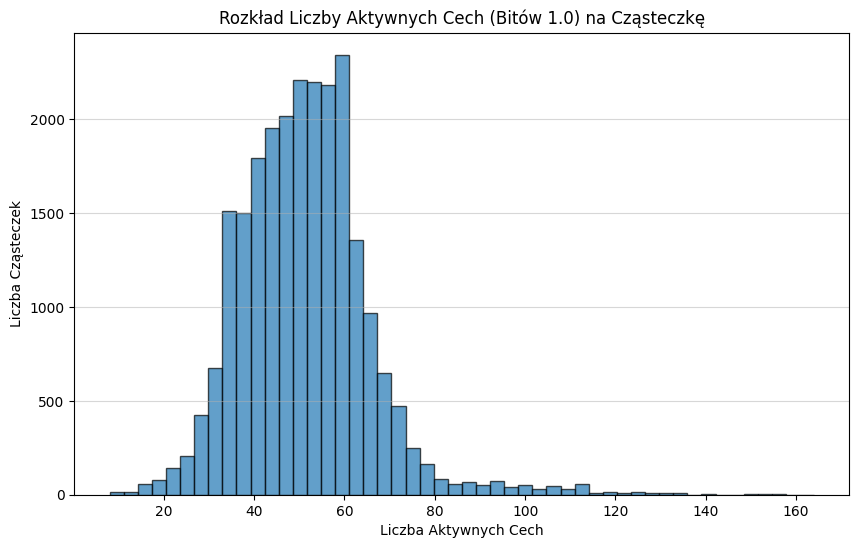

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(bit_counts, bins=50, edgecolor='black', alpha=0.7)
plt.title('Rozkład Liczby Aktywnych Cech (Bitów 1.0) na Cząsteczkę')
plt.xlabel('Liczba Aktywnych Cech')
plt.ylabel('Liczba Cząsteczek')
plt.grid(axis='y', alpha=0.5)
plt.show()

### Analiza unikalności danych

In [19]:
unique_ids_count = df_chembl_y["ID"].n_unique()

print(f"\nLiczba unikalnych identyfikatorów (SMILES) w zbiorze: {unique_ids_count}")
print(f"Całkowita liczba próbek: {len(mol_ids)}")


Liczba unikalnych identyfikatorów (SMILES) w zbiorze: 23871
Całkowita liczba próbek: 23871
